In [4]:
%pip install opencv-python
%pip install numpy
%pip install matplotlib

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.8/39.5 MB 10.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.2/39.5 MB 11.1 MB/s eta 0:00:04
   ------ --------------------------------- 6.8/39.5 MB 11.4 MB/s eta 0:00:03
   --------- ------------------------------ 9.2/39.5 MB 11.5 MB/s eta 0:00:03
   ----------- ---------------------------- 11.5/39.5 MB 11.6 MB/s eta 0:00:03
   -------------- ------------------------- 13.9/39.5 MB 11.6 MB/s eta 0:00:03
   ---------------- ----------------------- 16.3/39.5 MB 11.7 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/39.5 MB 11.7 MB/s eta 0:00:02
   --------------------- ------------------ 21.2/39.5 MB 11.7 MB/s eta 0:00:02
   ----------------------- ---------------- 23.6/39.5 MB 11.7 MB/s eta 0:00:02
   -------------------------- ------------- 26.0/39.5 MB 11.7 MB/s eta 0:00:02
   ---------------------------- ----------- 28.3/39.5 MB 11.7 MB/

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.0 MB 8.3 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.0 MB 10.3 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.0 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 12.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ------------------------------- -------- 2.1/2.6 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 11.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


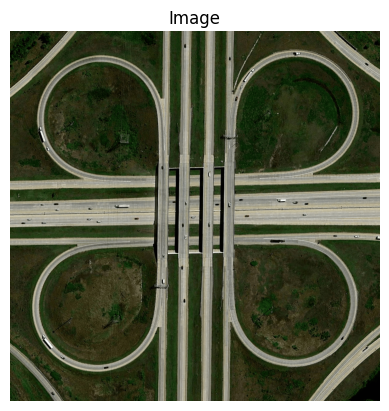

Image Dimensions: (1207, 1207, 3)
Pixel Value Range: 0 to 253


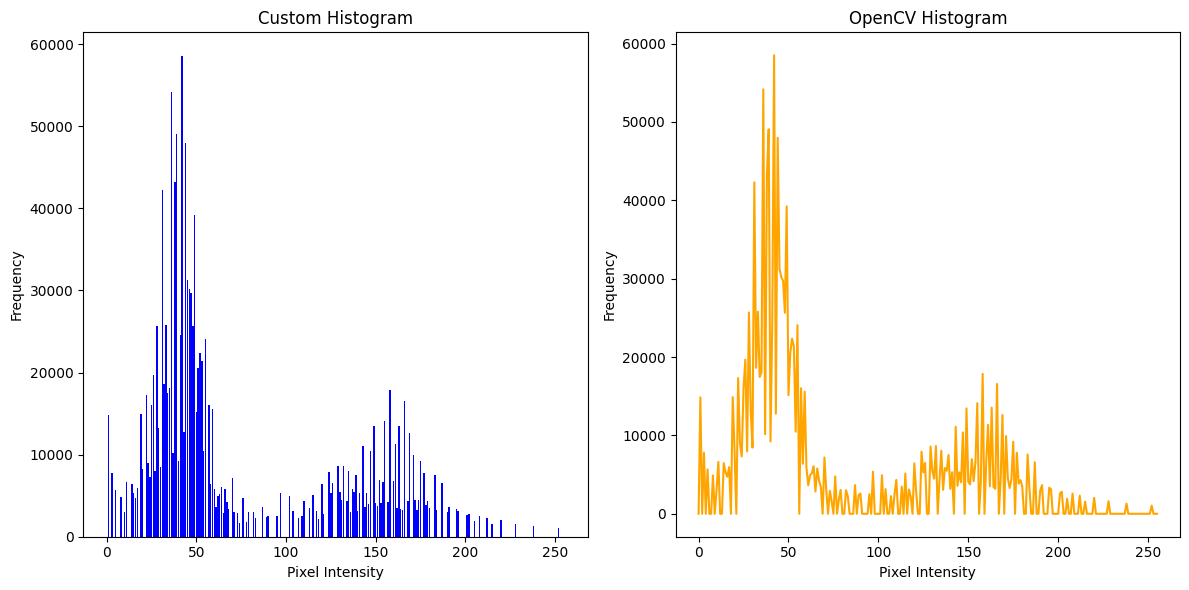

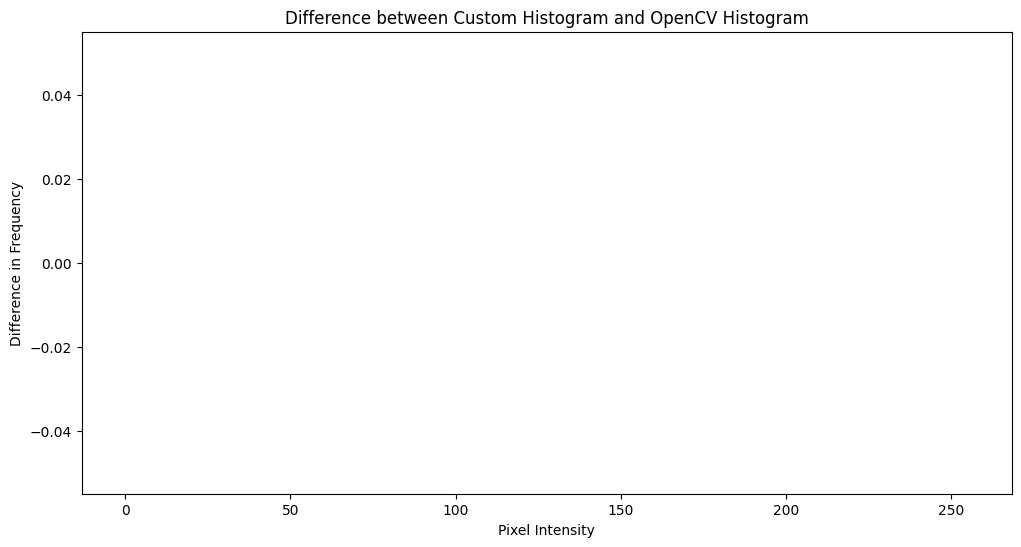

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_explore_image(file_path):
    # Load the image
    image = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("Image could not be loaded. Check the file path.")
        # Convert BGR to RGB for display with matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.title("Image")
    plt.axis('off')
    plt.show()
    dimensions = image.shape
    min_val, max_val = image.min(), image.max()
    print(f"Image Dimensions: {dimensions}")
    print(f"Pixel Value Range: {min_val} to {max_val}")
    histogram = np.zeros(256, dtype=int)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for pixel in grayscale_image.ravel():
        histogram[pixel] += 1
    opencv_hist = cv2.calcHist([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)], [0], None, [256], [0, 256]).flatten()
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(256), histogram, color='blue')
    plt.title("Custom Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.plot(opencv_hist, color='orange')
    plt.title("OpenCV Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()
    
    # Subtract the histograms
    histogram_difference = histogram - opencv_hist

# Plot the difference
    plt.figure(figsize=(12, 6))
    plt.bar(range(256), histogram_difference, color='purple')
    plt.title("Difference between Custom Histogram and OpenCV Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Difference in Frequency")
    plt.show()
    return image

image_path = 'cloverleaf_interchange.png'

image = load_and_explore_image(image_path)




There arent any differences in the output of our custom histogram and opencvs histogram , the main difference lies in the way they are made,
More specifically OpenCV's calchist() function is highly optimised and implemented in C/C++ enabling faster lower level optimisations that arent possible with the custom histogram implementation done in python (incurring python overhead)

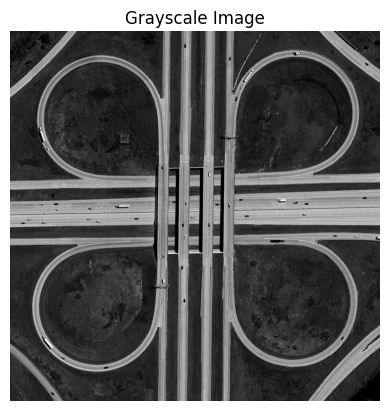

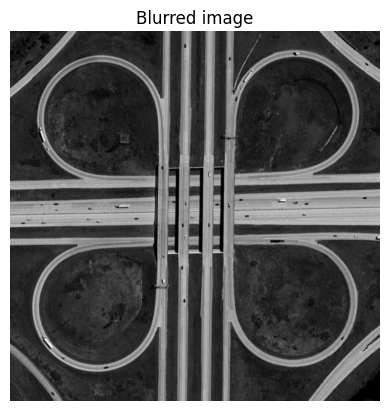

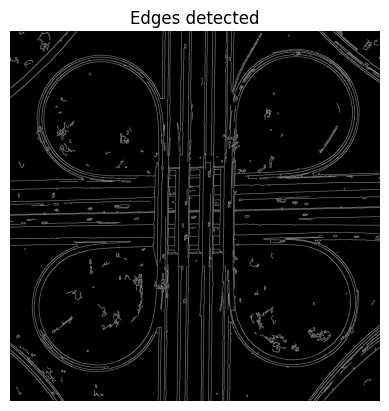

In [6]:

def preprocess_image(image):
    # Step 1: Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(grayscale,cmap="gray")
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Step 2: Noise reduction using Gaussian Blur
    blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)
    plt.imshow(blurred,cmap="gray")
    plt.title("Blurred image")
    plt.axis('off')
    plt.show()

    # Step 3: Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    plt.imshow(edges,cmap="gray")
    plt.title("Edges detected")
    plt.axis('off')
    plt.show()

    return edges

preprocessed_image = preprocess_image(image)

Justifications for such preprocessing steps are as follows ,

Use of Grayscale image instead of rgb image reduces the channels to be processed from 3 to 1 enabling faster computation since colour information is irrelevant compared to intensity differences of the overall image for this specific task

Then we blurr the image since we will be doing edge detection next , so blurring the image will cause the noise artifacts to be curbed a bit so they dont show up as false edges , also it will smoothen the image for better processing.

Lastly we do Canny edge detection reasons:
1.Reason for using this over other edge detection methods is because of its double thresholding , which retains weaker edges connected to strong edges but discards isolated weak edges (likely noise)
2.Since we will be performing Hough's circle transform later on , canny's gradient specific edge detection aligns with the requirements (gives sharp well-localised edges crucial for houghs transform)


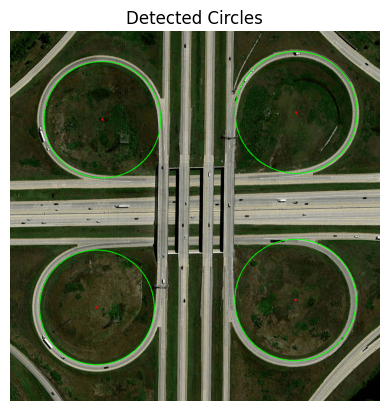

Detected circles (x, y, radius):
[283 901 187]
[933 265 199]
[301 289 190]
[931 877 198]


In [7]:
def detect_cloverleaves(image, edges):
    # Step 1: Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=500,        # Minimum distance between circles
        param1=100,        # Canny edge detection threshold (higher)
        param2=30,         # Accumulator threshold for circle detection
        minRadius=150,      # Minimum circle radius
        maxRadius=200      # Maximum circle radius
    )

    # Step 2: Visualize detected circles
    output_image = image.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round and convert to integer
        for circle in circles[0, :]:
            x, y, r = circle
            # Draw the circle
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Green circle
            # Draw the center
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # Red center

    # Step 3: Display the result
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Circles")
    plt.axis('off')
    plt.show()

    return output_image, circles

# Use the edge-detected image from the preprocessing step
output_image, detected_circles = detect_cloverleaves(image, preprocessed_image)

# Print details about detected circles
if detected_circles is not None:
    print("Detected circles (x, y, radius):")
    for circle in detected_circles[0, :]:
        print(circle)
else:
    print("No circles detected.")

Impact of preprocessing on houghs circle transform:
Grayscale conversion helps reduce computation complexity (circle transform takes parameterisation of edges into 3d space) and makes it focus on structure of the object in the image instead of the colour variations.
Blurring helps with reducing noisy artifacts that might show up as edges and result in poor performance for hough transform
Lastly the gradient specific double thresholded edges detected using Canny edge detection ensures that Hough transform works as intended.


Explanation of Hough Transform:
Firstly the circles in 2d images can be represented by their centre coordinates (x and y) and their radius ,

So what hough transforms does is , when fed with an image of edge points , it makes each edge point cast a projection into a 3d parametric space of x,y,r meaning every edge point casts a projection into this space for the possible circles that it can be a part of (infinite but that is restrained by the parameters we give to the function) now as each edge point is processed , the edge pixels that are on circle cast projections again and again into a specific (x,y,r) coordinate in the 3d space, 
finally after this mapping is done , the votes are stored in the space and a local maxima detector runs over the space with an accumulator threshold value , if it finds a coordinate crossing this , its decided that this circle with centre x,y and radius r exists in the original image


Some advantages are for this specific problem is that houghs transform will detect incomplete circles too (with a proper accumulator threshold value) since a cloverleaf isnt a full circle this is the perfect algorithm to use to detect it and its centre

Some challenges I faced were setting the right min_dist (minimum distance between detected circles) min and max radius , and thats basically it.

The cases where it can fail is mainly due to noise it might cause false detection of circles , if the noise edges are casting comparable number of votes as true circle edges then the detection scheme is ambiguous and wont be able to differentiate the fake from the true circles.

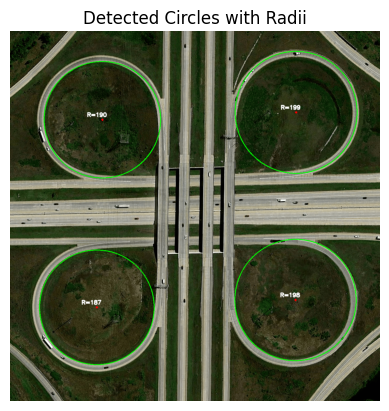

Estimated Radii (in pixels):
[np.uint16(187), np.uint16(199), np.uint16(190), np.uint16(198)]


In [9]:
def calculate_radii(image, circles):
    # Make a copy of the original image to annotate
    output_image = image.copy()

    # Check if any circles were detected
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round and convert to integer
        radii = []

        # Loop through detected circles
        for i, circle in enumerate(circles[0, :]):
            x, y, r = circle
            radii.append(r)  # Append the radius to the list

            # Draw the circle
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Green circle
            # Draw the center
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # Red center
            # Annotate the radius on the image
            cv2.putText(
                output_image,
                f"R={r}",
                (x - 50, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (255, 255, 255),
                2,
                cv2.LINE_AA
            )

        # Display the annotated image
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Circles with Radii")
        plt.axis('off')
        plt.show()

        # Print the radii
        print("Estimated Radii (in pixels):")
        print(radii)

        return radii
    else:
        print("No circles were detected.")
        return []

# Call the function to calculate and display radii
radii = calculate_radii(image, detected_circles)

We are easily able to detect the radius from the detected circles because the very nature of Houghs circle transform provides us with centre and radius of the detected circles as the output

Now the challenging thing here is its unable to differentiate between the outer road lane and inner road lane (setting the min dist any lower causes noisy circles to arise) meaning some of the radius estimations are off by some pixels since its taking half circle from inner edge of road and half from outer 



In [10]:
def calculate_area(radii):
    areas = []
    for r in radii:
        area = np.pi * (r ** 2)  # Area of a circle
        areas.append(area)
    return areas

# Call the function and calculate the areas
areas = calculate_area(radii)
def calculate_area_pixel_count(image, circles):
    # Create a blank black image the same size as the input
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round and convert to integer
        areas = []

        for i, circle in enumerate(circles[0, :]):
            x, y, r = circle

            # Draw a filled circle on the mask
            cv2.circle(mask, (x, y), r, 255, -1)

            # Count the number of white pixels inside the circle
            area = np.sum(mask == 255)
            areas.append(area)

            # Reset the mask for the next circle
            mask[:, :] = 0

        return areas
    else:
        print("No circles detected.")
        return []

# Call the function to calculate areas by pixel count
pixel_areas = calculate_area_pixel_count(image, detected_circles)

# Print the results
print("Approximate Areas assuming perfect circle:")
for i, area in enumerate(areas):
    print(f"Cloverleaf {i + 1}: {area:.2f} square pixels")

print("Approximate Areas (via Pixel Counting, in square pixels):")
for i, area in enumerate(pixel_areas):
    print(f"Cloverleaf {i + 1}: {area} square pixels")
# Print the results


Approximate Areas assuming perfect circle:
Cloverleaf 1: 109858.35 square pixels
Cloverleaf 2: 124410.21 square pixels
Cloverleaf 3: 113411.49 square pixels
Cloverleaf 4: 123163.00 square pixels
Approximate Areas (via Pixel Counting, in square pixels):
Cloverleaf 1: 109845 square pixels
Cloverleaf 2: 124381 square pixels
Cloverleaf 3: 113369 square pixels
Cloverleaf 4: 123121 square pixels


nearly similar results , but I have one more thing in mind , the cloverleaf isnt exactly a perfect circle , from how I see it , its more like 3/4th circle and the rest is a square (side_length = radius), so i will print this area too for exploration and completion

In [11]:
def calculate_area_hypothetical(radii):
    areas = []
    for r in radii:
        area = (r ** 2) * (3 * np.pi / 4 + 1)   # Area of a circle
        areas.append(area)
    return areas

areas = calculate_area_hypothetical(radii)

print("Approximate Areas assuming 3 quarters circle and a square:")
for i, area in enumerate(areas):
    print(f"Cloverleaf {i + 1}: {area:.2f} square pixels")



Approximate Areas assuming 3 quarters circle and a square:
Cloverleaf 1: 117362.77 square pixels
Cloverleaf 2: 132908.66 square pixels
Cloverleaf 3: 121158.62 square pixels
Cloverleaf 4: 131576.25 square pixels


significantly different from the above two estimations , albeit i Dont know which one is closer to the correct answer.